In [1]:
import os

import numpy as np
import pandas as pd

evaluation_dir = os.path.join(os.getcwd(), '..', 'evaluation', 'signals')
predictions_file = os.path.join(evaluation_dir, 'predictions.csv')

predictions = pd.read_csv(predictions_file)
predictions['signal'] = predictions['signal'].apply(eval).apply(np.array)
predictions['parameters'] = predictions['parameters'].apply(eval).apply(dict)
predictions['execution_time'] = pd.to_timedelta(predictions['execution_time'])
predictions['roi'] = predictions['parameters'].apply(lambda param: param['roi'])

ground_truth_file = os.path.join(evaluation_dir, 'ground_truth.csv')
ground_truth = pd.read_csv(ground_truth_file)
ground_truth['signal'] = ground_truth['signal'].apply(eval).apply(np.array)

predictions.head()

,subject,scenario,method,parameters,execution_time,sampling_rate,signal,roi
0,Proband01,101_natural_lighting,pixel_intensity,"{'roi': 'full', 'roi_area': [0, 0, 640, 480]}",0 days 00:00:00.558247,30,"[160.318876953125, 160.31729817708333, 160.319...",full
1,Proband01,101_natural_lighting,optical_flow,"{'roi': 'full', 'roi_area': [0, 0, 640, 480], ...",0 days 00:00:01.395307,30,"[447.5668478158486, 447.55095241817645, 447.53...",full
2,Proband01,101_natural_lighting,optical_flow,"{'roi': 'full', 'roi_area': [0, 0, 640, 480], ...",0 days 00:00:01.439088,30,"[464.8666476090648, 464.84217513715316, 464.82...",full
3,Proband01,101_natural_lighting,pixel_intensity,"{'roi': 'chest', 'roi_area': [265, 430, 133, 66]}",0 days 00:00:00.021963,30,"[144.23864661654136, 144.1996992481203, 144.24...",chest
4,Proband01,101_natural_lighting,optical_flow,"{'roi': 'chest', 'roi_area': [265, 430, 133, 6...",0 days 00:00:01.137153,30,"[576.2930666175787, 576.2187359947692, 576.173...",chest


## Frequency extraction evaluation

In [2]:
from respiratory_extraction.models.frequency_extraction import FrequencyExtractor

frequency_results = []

for index, row in predictions.iterrows():
    subject, scenario = row['subject'], row['scenario']

    # Get the ground truth signal and sampling rate
    gt_signal, gt_sampling_rate = ground_truth[
        (ground_truth['subject'] == subject) &
        (ground_truth['scenario'] == scenario)
        ][['signal', 'sampling_rate']].values[0]

    gt_extractor = FrequencyExtractor(
        gt_signal,
        gt_sampling_rate,
        lowpass=0.1,
        highpass=0.6)

    gt_frequencies = {
        'fft': gt_extractor.frequency_from_fft(),
        'pc': gt_extractor.frequency_from_peaks(),
        'cp': gt_extractor.frequency_from_crossing_point(),
        'nfcp': gt_extractor.frequency_from_nfcp(),
    }

    frequency_extractor = FrequencyExtractor(
        row['signal'],
        row['sampling_rate'],
        lowpass=0.1,
        highpass=0.6,
    )
    predicted_frequencies = {
        'fft': frequency_extractor.frequency_from_fft(),
        'pc': frequency_extractor.frequency_from_peaks(),
        'cp': frequency_extractor.frequency_from_crossing_point(),
        'nfcp': frequency_extractor.frequency_from_nfcp(),
    }

    for method in gt_frequencies.keys():
        # The frequency is in Hz, we want to convert it to bpm
        predicted_bpm = predicted_frequencies[method] * 60
        gt_bpm = gt_frequencies[method] * 60

        frequency_results.append({
            'subject': subject,
            'scenario': scenario,
            'strategy': row['method'],
            'parameters': row['parameters'],
            'execution_time': row['execution_time'],
            'method': method,
            'gt_bpm': predicted_bpm,
            'predicted_bpm': gt_bpm,
            'error': round(abs(gt_bpm - predicted_bpm), 2),
        })

In [3]:
frequency_df = pd.DataFrame(frequency_results)
frequency_df

,subject,scenario,strategy,parameters,execution_time,method,gt_bpm,predicted_bpm,error
0,Proband01,101_natural_lighting,pixel_intensity,"{'roi': 'full', 'roi_area': [0, 0, 640, 480]}",0 days 00:00:00.558247,fft,7.50,22.473282,14.97
1,Proband01,101_natural_lighting,pixel_intensity,"{'roi': 'full', 'roi_area': [0, 0, 640, 480]}",0 days 00:00:00.558247,pc,22.00,21.984733,0.02
2,Proband01,101_natural_lighting,pixel_intensity,"{'roi': 'full', 'roi_area': [0, 0, 640, 480]}",0 days 00:00:00.558247,cp,21.25,21.984733,0.73
3,Proband01,101_natural_lighting,pixel_intensity,"{'roi': 'full', 'roi_area': [0, 0, 640, 480]}",0 days 00:00:00.558247,nfcp,23.00,22.473282,0.53
4,Proband01,101_natural_lighting,optical_flow,"{'roi': 'full', 'roi_area': [0, 0, 640, 480], ...",0 days 00:00:01.395307,fft,8.50,22.473282,13.97
...,...,...,...,...,...,...,...,...,...
931,Proband26,101_natural_lighting,optical_flow,"{'roi': 'person', 'roi_area': [164, 138, 372, ...",0 days 00:00:01.205342,nfcp,21.50,15.369759,6.13
932,Proband26,101_natural_lighting,optical_flow,"{'roi': 'person', 'roi_area': [164, 138, 372, ...",0 days 00:00:01.474552,fft,14.00,14.149936,0.15
933,Proband26,101_natural_lighting,optical_flow,"{'roi': 'person', 'roi_area': [164, 138, 372, ...",0 days 00:00:01.474552,pc,16.00,14.637865,1.36
934,Proband26,101_natural_lighting,optical_flow,"{'roi': 'person', 'roi_area': [164, 138, 372, ...",0 days 00:00:01.474552,cp,17.50,14.881830,2.62


In [22]:
frequency_df[
    (frequency_df['subject'] == 'Proband15') &
    (frequency_df['scenario'] == '101_natural_lighting') &
    (frequency_df['strategy'] == 'optical_flow') & 
    (frequency_df['method'] == 'fft')
]

,subject,scenario,strategy,parameters,execution_time,method,gt_bpm,predicted_bpm,error
508,Proband15,101_natural_lighting,optical_flow,"{'roi': 'full', 'roi_area': [0, 0, 640, 480], ...",0 days 00:00:01.251795,fft,14.5,14.146341,0.35
512,Proband15,101_natural_lighting,optical_flow,"{'roi': 'full', 'roi_area': [0, 0, 640, 480], ...",0 days 00:00:01.483841,fft,14.5,14.146341,0.35
520,Proband15,101_natural_lighting,optical_flow,"{'roi': 'chest', 'roi_area': [266, 420, 117, 5...",0 days 00:00:01.292790,fft,14.5,14.146341,0.35
524,Proband15,101_natural_lighting,optical_flow,"{'roi': 'chest', 'roi_area': [266, 420, 117, 5...",0 days 00:00:01.007650,fft,14.5,14.146341,0.35
532,Proband15,101_natural_lighting,optical_flow,"{'roi': 'person', 'roi_area': [149, 191, 337, ...",0 days 00:00:01.117364,fft,14.5,14.146341,0.35
536,Proband15,101_natural_lighting,optical_flow,"{'roi': 'person', 'roi_area': [149, 191, 337, ...",0 days 00:00:01.427482,fft,14.5,14.146341,0.35


## Compare the signal with the ground truth

In [4]:
from scipy.spatial import distance
from scipy.signal import detrend

In [5]:
# test_subject = 'Proband15'
test_subject = 'Proband05'

scenario = predictions[
    (predictions['subject'] == test_subject) &
    (predictions['scenario'] == '101_natural_lighting') &
    (predictions['method'] == 'optical_flow') &
    (predictions['roi'] == 'chest')]

prediction = scenario[
    (scenario['parameters'].apply(lambda param: param['use_cgof']))
].iloc[0]

prediction_signal = prediction['signal']

In [6]:
from scipy.signal import resample

ground_truth_signal = ground_truth[
    (ground_truth['subject'] == test_subject) &
    (ground_truth['scenario'] == '101_natural_lighting')
    ].iloc[0]

# Down sample the signal to predict the frequency
ground_truth_signal = resample(ground_truth_signal['signal'], len(prediction['signal']))

gt_detrend = detrend(ground_truth_signal)

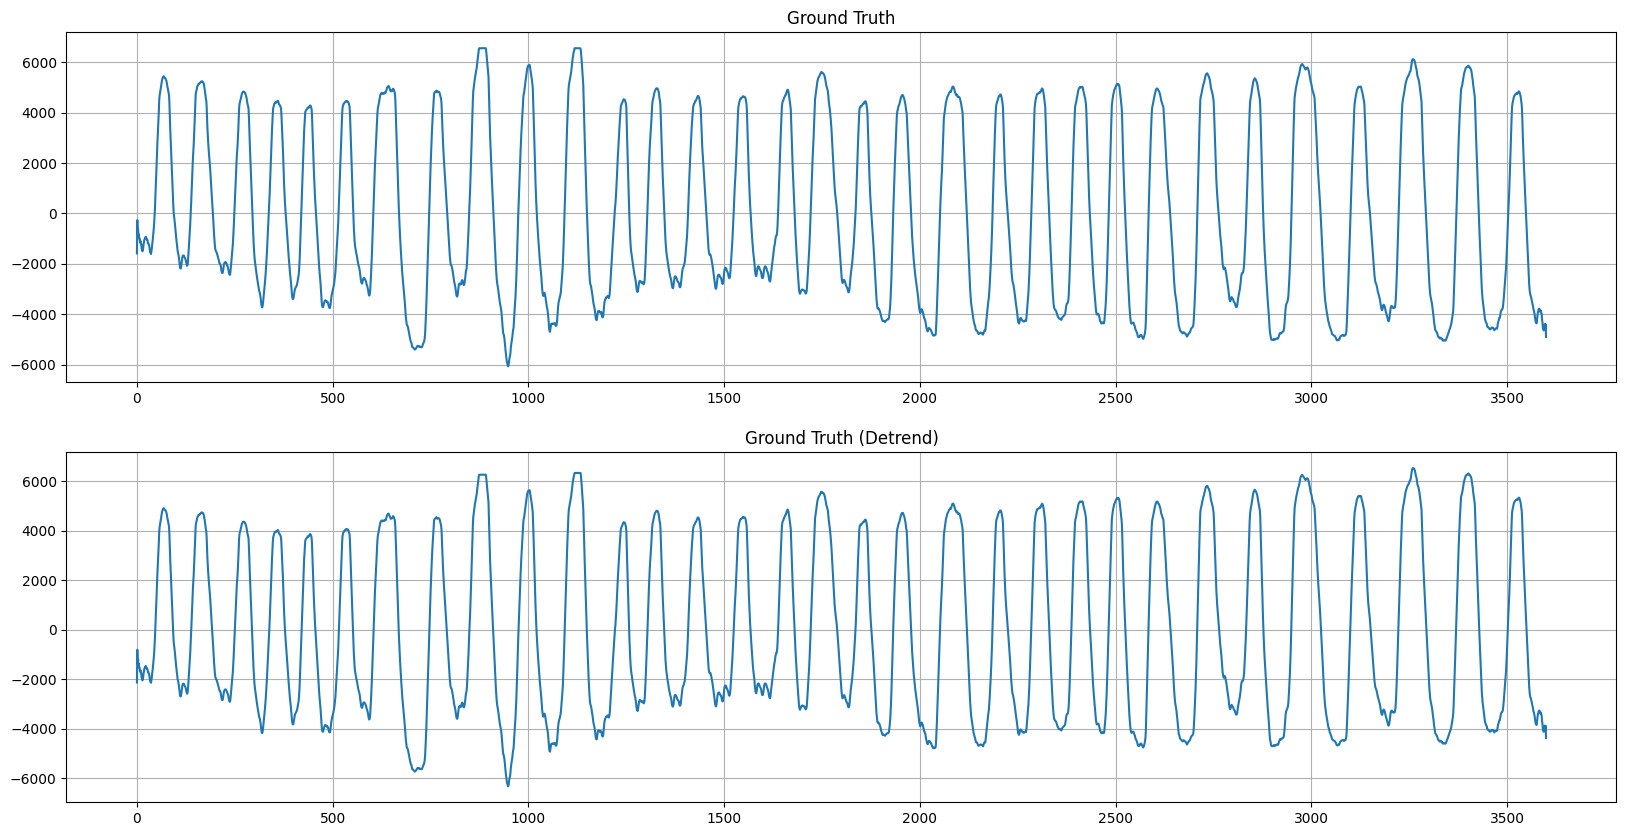

In [7]:
import matplotlib.pyplot as plt

_, axs = plt.subplots(2, 1, figsize=(20, 10))

# Plot the ground truth signal and the predicted signal
axs[0].set_title('Ground Truth')
axs[0].plot(ground_truth_signal, label='Ground Truth')
axs[0].grid(True)

axs[1].set_title('Ground Truth (Detrend)')
axs[1].plot(gt_detrend, label='Ground Truth (Detrend)')
axs[1].grid(True)

In [8]:
prediction_detrend = detrend(prediction_signal)

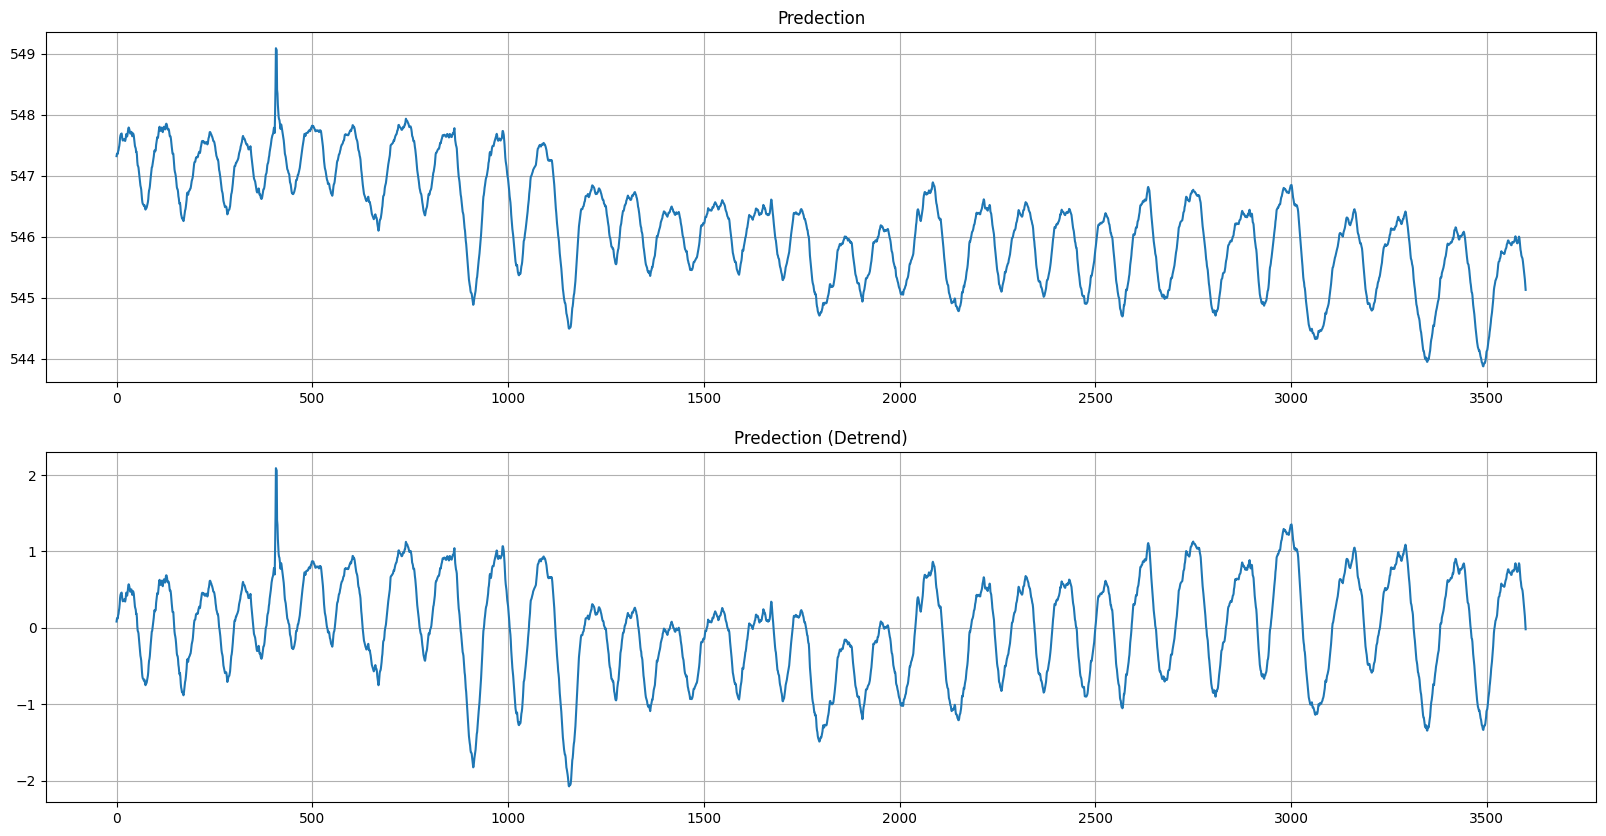

In [9]:
import matplotlib.pyplot as plt

_, axs = plt.subplots(2, 1, figsize=(20, 10))

# Plot the ground truth signal and the predicted signal
axs[0].set_title('Predection')
axs[0].plot(prediction_signal, label='Predection')
axs[0].grid(True)

axs[1].set_title('Predection (Detrend)')
axs[1].plot(prediction_detrend, label='Predection')
axs[1].grid(True)

In [10]:
import respiratory_extraction.models.signal_preprocessing as sp

gt_normalized = sp.normalize_signal(gt_detrend)
pd_normalized = sp.normalize_signal(prediction_detrend)

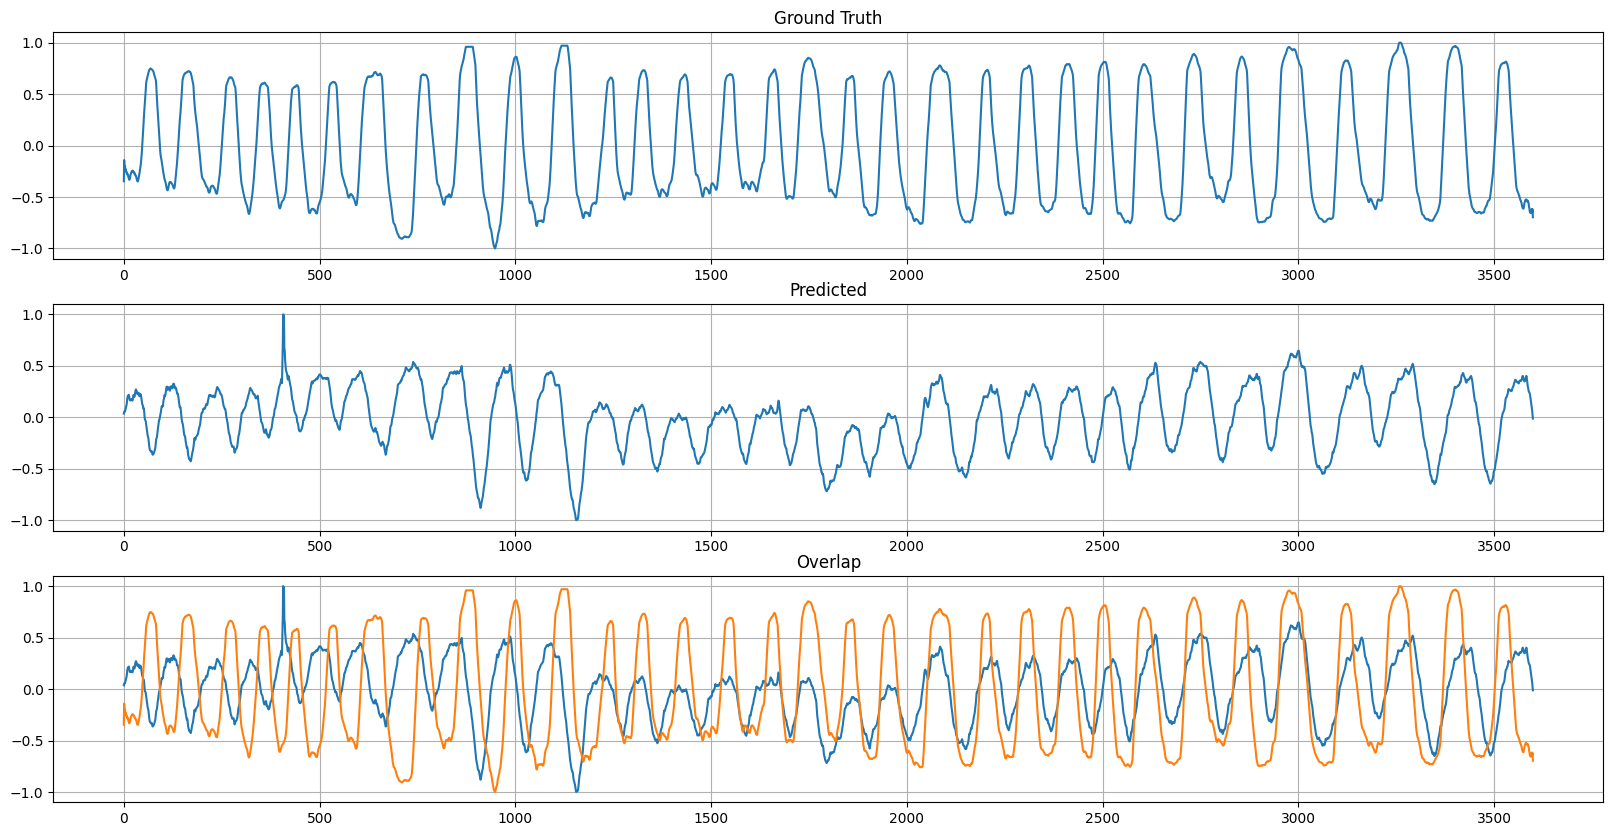

In [11]:
import matplotlib.pyplot as plt

_, axs = plt.subplots(3, 1, figsize=(20, 10))

# Plot the ground truth signal and the predicted signal
axs[0].set_title('Ground Truth')
axs[0].plot(gt_normalized, label='Ground Truth')
axs[0].grid(True)

axs[1].set_title('Predicted')
axs[1].plot(pd_normalized, label='Predicted')
axs[1].grid(True)

# Plot the ground truth signal and the predicted signal
axs[2].set_title('Overlap')
axs[2].plot(pd_normalized, label='Prediction')
axs[2].plot(gt_normalized, label='Ground Truth')
axs[2].grid(True)

In [12]:
gt_filtered = sp.butterworth_filter(gt_normalized, prediction['sampling_rate'], 0.05, 0.6)
pd_filtered = sp.butterworth_filter(pd_normalized, prediction['sampling_rate'], 0.05, 0.6)

gt_filtered = sp.normalize_signal(gt_filtered)
pd_filtered = sp.normalize_signal(pd_filtered)

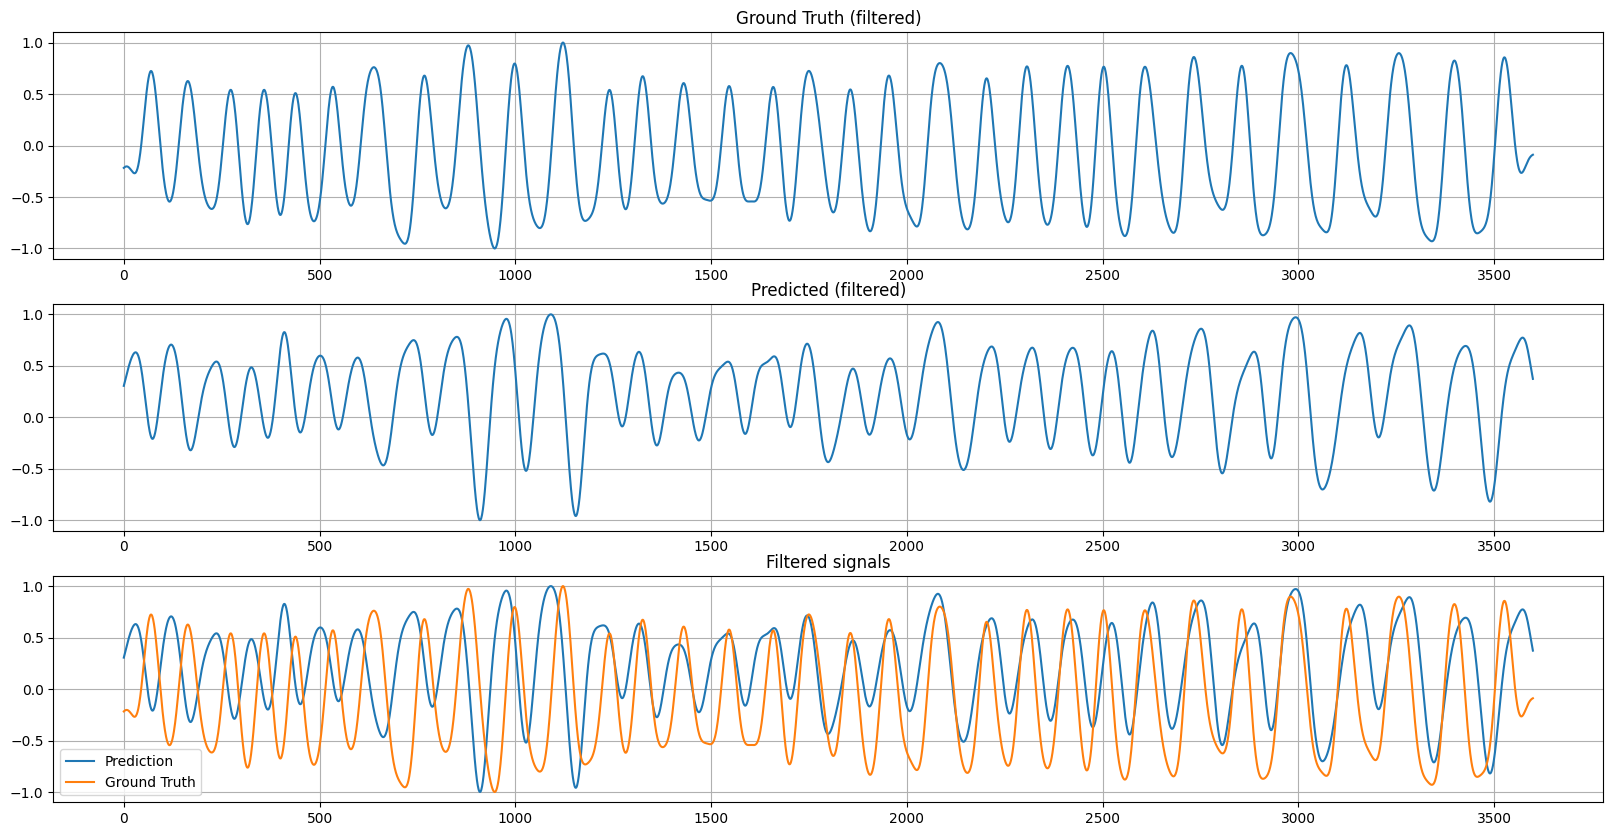

In [13]:
import matplotlib.pyplot as plt

_, axs = plt.subplots(3, 1, figsize=(20, 10))

axs[0].set_title('Ground Truth (filtered)')
axs[0].plot(gt_filtered, label='Ground Truth')
axs[0].grid(True)

axs[1].set_title('Predicted (filtered)')
axs[1].plot(pd_filtered, label='Predicted')
axs[1].grid(True)

# Plot the ground truth signal and the predicted signal
axs[2].set_title('Filtered signals')
axs[2].plot(pd_filtered, label='Prediction')
axs[2].plot(gt_filtered, label='Ground Truth')
axs[2].grid(True)
axs[2].legend()

In [14]:
correlate_result = np.correlate(gt_filtered, pd_filtered, 'full')
best_correlation_index = np.argmax(correlate_result)
shift_amount = (-len(pd_filtered) + 1) + best_correlation_index

if shift_amount == 0:
    pd_shifted = pd_filtered
    gt_shifted = gt_filtered
elif shift_amount <= 0:
    # Shift the signal to the left
    pd_shifted = pd_filtered[abs(shift_amount):]
    # Remove the last values from the ground truth signal
    gt_shifted = gt_filtered[:shift_amount]
else:
    # Shift the signal to the right
    pd_shifted = pd_filtered[:-shift_amount]
    # Remove the last values from the ground truth signal
    gt_shifted = gt_filtered[:-shift_amount]

shift_amount

-432

In [15]:
# Calculate the correlation coefficient
correlation_shift = np.corrcoef(pd_filtered, gt_filtered)[0, 1]
correlation_shift

0.34158848653293944

In [16]:
# Calculate the correlation coefficient
correlation_shift = np.corrcoef(pd_shifted, gt_shifted)[0, 1]
correlation_shift

0.40611229134357474

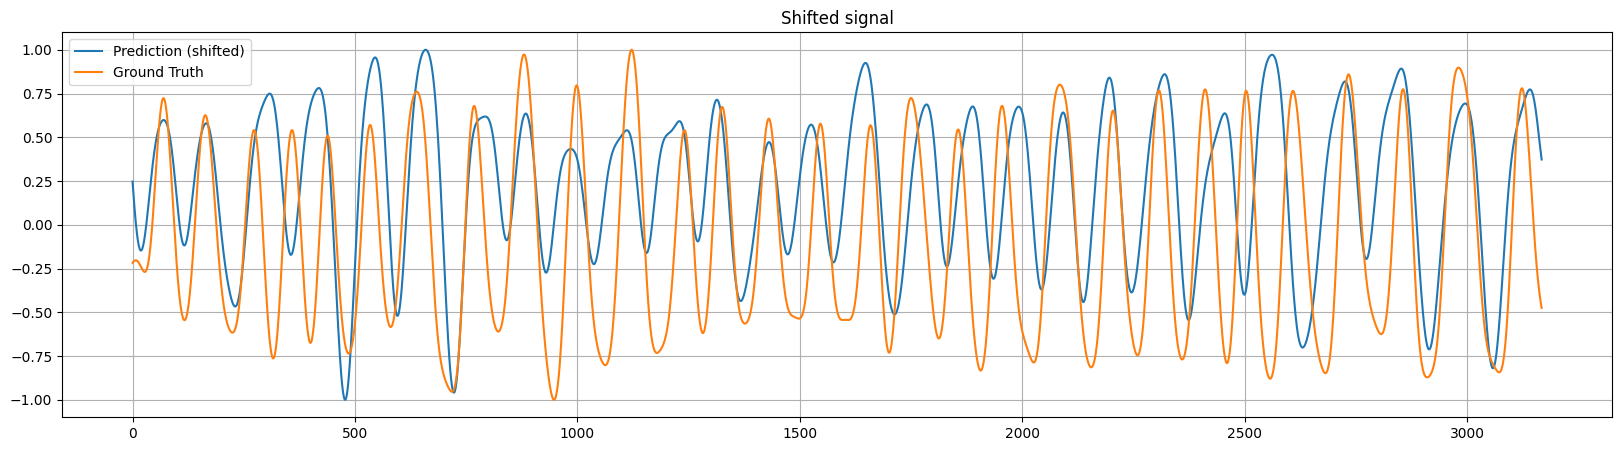

In [17]:
# Plot the ground truth signal and the predicted signal
plt.figure(figsize=(20, 5))
plt.title('Shifted signal')
plt.plot(pd_shifted, label='Prediction (shifted)')
plt.plot(gt_shifted, label='Ground Truth')
plt.grid(True)
plt.legend()

In [18]:
dist_normalized = distance.euclidean(pd_normalized, gt_normalized)
dist_filtered = distance.euclidean(pd_filtered, gt_filtered)
dist_shifted = distance.euclidean(pd_shifted, gt_shifted)

print(f'dist_normalized: {dist_normalized:.2f}')
print(f'dist_filtered:   {dist_filtered:.2f}')
print(f'dist_shifted:    {dist_shifted:.2f}')

dist_normalized: 33.91
dist_filtered:   38.42
dist_shifted:    34.46


In [19]:
import scipy.stats as stats

normalized_correlation, _ = stats.pearsonr(pd_normalized, gt_normalized)
filtered_correlation, _ = stats.pearsonr(pd_filtered, gt_filtered)
shifted_correlation, _ = stats.pearsonr(pd_shifted, gt_shifted)

print(f'Normalized: {normalized_correlation:.4f}')
print(f'Filtered:   {filtered_correlation:.4f}')
print(f'Shifted:    {shifted_correlation:.4f}')

Normalized: 0.2902
Filtered:   0.3416
Shifted:    0.4061
